In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
def read_mprof(path):
    times = []
    mem = []
    func_ts = {}
    with open(path) as fd:
        for l in fd:
            key, val = l.split(' ', 1)
            if key == 'MEM':
                values = val.split(' ')
                mem.append(float(values[0]))
                times.append(float(values[1]))
            elif key == 'FUNC':
                values = val.split(' ')
                fname, mem_start, start, mem_end, end = values[:5]
                ts = func_ts.get(fname, [])
                ts.append([float(start), float(end), float(mem_start), float(mem_end)])
                func_ts[fname] = ts
    return {
        'mem_usage': np.array([times, mem]).transpose(),
        'func_timestamp': func_ts
    }

In [3]:
def plot_mprof(mprof_data):
    mem_usage = mprof_data['mem_usage']
    ts = mprof_data['func_timestamp']
    # Memory
    abs_start = mem_usage[0, 0]
    displaced_time = mem_usage[:, 0] - abs_start
    plt.plot(displaced_time, mem_usage[:, 1])
    # Max value
    max_val = max(mem_usage[:, 1])
    plt.plot([displaced_time[0], displaced_time[-1]], [max_val, max_val], 'r--', label="%.2f MB" % max_val)
    # Functions
    i = 0
    style = ['v', '^', '<', '>']
    for f, exec_ts in ts.items():
        f = f.replace('_', '')
        for execution in exec_ts:
            start, end, mstart, mend = execution
            start -= abs_start
            end -= abs_start
            plt.plot([start, end], [mstart, mend], style[i % len(style)] + ':', label=f)
            i += 1
    # Legend
    plt.legend()

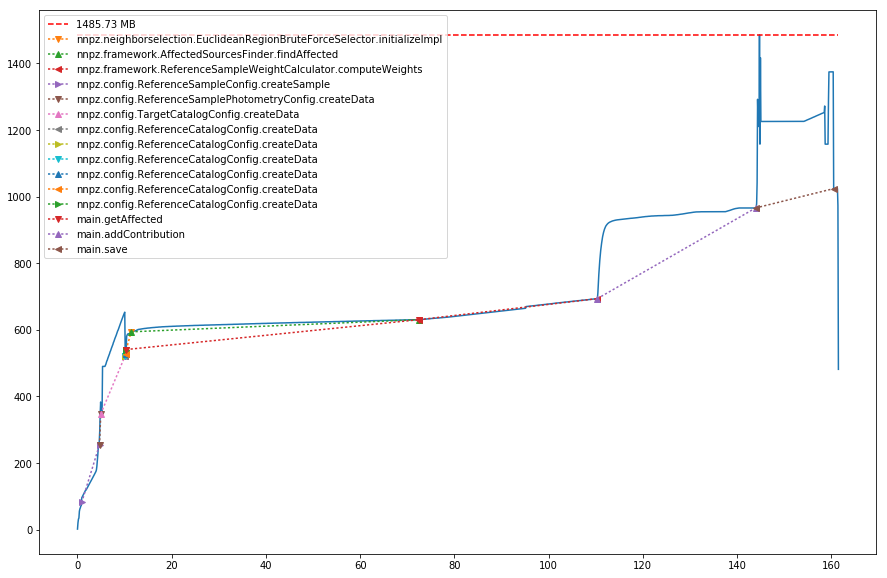

In [4]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180515155710.dat')
plot_mprof(mprof_data)

The KDD tree doesn't seem to take that much space. In any case, the memory isn't released even
when forcing it to fall out of scope/delete it.

Ah, of course. A reference is hold by the ConfigManager and NeighborSelectorConfig, so it is not as straight-forward to release.

**Note**: Forcing the destruction with a very dirty trick only saves a meager 35 MiB